# Modeling
In this notebook I will create some deep learning models to address the colorization task.

In [47]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import json

import tensorflow as tf

from tensorflow import keras

from keras.layers import Conv2D, UpSampling2D, Dense, MaxPooling2D, BatchNormalization, Conv2DTranspose
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

from sklearn.model_selection import train_test_split

from skimage.color import rgb2lab, lab2rgb
from skimage.transform import resize
from skimage.io import imsave, imshow

from mpl_toolkits.axes_grid1 import ImageGrid

import random

import visualkeras

In [2]:
seed = 42
random.seed(seed)
dataset_path = "../preprocessed/"
path = '../dataset/'
models_path = "../models/"
history_path = "../models/history/"

## Utility functions

In [3]:
def plot_history(history,model_name):
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    ax = axes.ravel()

    # accuracy
    ax[0].plot(history['accuracy'])
    ax[0].plot(history['val_accuracy'])
    ax[0].set_title('model accuracy')
    ax[0].set_ylabel('accuracy')
    ax[0].set_xlabel('epochs')
    ax[0].legend(['train', 'validation'], loc='upper left')

    # summarize history for loss
    ax[1].plot(history['loss'])
    ax[1].plot(history['val_loss'])
    ax[1].set_title('model loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epochs')
    ax[1].legend(['train', 'validation'], loc='upper right')

    fig.tight_layout()
    fig.suptitle(model.name,fontsize=16)
    plt.show()      

In [4]:
def plot_history_comparison(validation=True,figsize=(6,6)):    

    plt.rcParams["figure.figsize"] = figsize
    plt.title('Validation accuracies')
    plt.ylabel('accuracy')
    plt.ylim([0.45, 0.8])
    plt.xlabel('epochs')

    models = []

    for name in os.listdir(history_path):    
        
        history_loaded = json.load(open(history_path+name, 'r'))       
        
        if validation:
            if "-ms" in name:                                
                plt.plot(history_loaded['val_accuracy'])
                models.append(name.replace("-ms.json",""))
        else:
            if not "-ms" in name:
                plt.plot(history_loaded['val_accuracy'])
                models.append(name.replace(".json",""))

    plt.legend(models, loc='upper left')
    
    plt.show() 

In [5]:
def plot_comparison(img_resized,img_recolored, figsize=(10,5),cast=False):     
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    ax = axes.ravel()

    ax[0].imshow(img_resized.astype('uint8') if cast else img_resized)
    ax[0].set_title("Resized")
    
    ax[1].imshow(img_recolored)
    ax[1].set_title("Recolored")

    fig.tight_layout()
    plt.show()      

### Image Size Problem
The literature addresses the colorization problem with rescaled images typically of size $256\times256$. However, due to limitated resources and time, I had to lower the number of input pixels to $128\times128$.

The difference in training time is quite large and it would be impossibile in a reasonable amount of time to test different model architecture an correctly validate some hyper-parameters.

Literature image input size: $$256\times256 = 2^8\times2^8 = 2^{16}$$

My lower image input size: $$128\times128 = 2^7\times2^7 = 2^{14}$$

There is a difference of $4$ times between the two image resolutions and this enables me to run $4$ times the number of test in order to validate my models. Eventually, once I found the best model, I will train it with the full $256\times256$ resolution, in order to compare to previous methods.

I know it is not an optimal procedure but I had to face time, memory and computational constraints.

In [6]:
SIZE = 128 # this is the target size of the entire process

### Dataset sample visualization

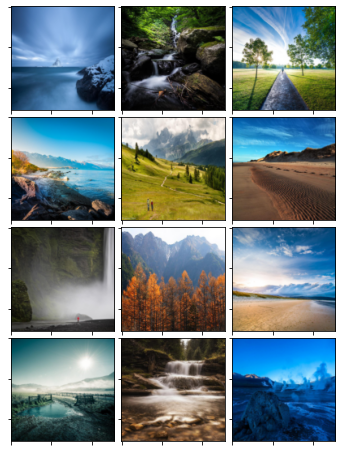

In [7]:
visualization_path = path+"download/landscapes4k/" # modify here to load images from a different folder
images = []
for img_path in os.listdir(visualization_path)[12:24]:    
    
    img_color = []
    img = img_to_array(load_img(visualization_path+img_path))
    
    img = resize(img, (SIZE,SIZE))
    images.append(img)
    
fig = plt.figure(figsize=(8., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, images):
    # Iterating over the grid returns the Axes.
    ax.imshow(im.astype('uint8'))
    ax.set_yticklabels([])
    ax.set_xticklabels([])

plt.show()

## Pre-processing

In this stage I load the dataset from disk and apply some transformations:
- rescale between 0 and 1 _(this normalization is useful to neural network training)_
- resize images to $SIZE \times SIZE$

In [10]:
train_datagen = ImageDataGenerator(rescale=1. / 255)

#Resize images, if needed
train = train_datagen.flow_from_directory(path+"download/", 
                                          target_size=(SIZE, SIZE), 
                                          batch_size=4300, 
                                          class_mode=None)

Found 4300 images belonging to 1 classes.


In [11]:
#Convert from RGB to Lab
"""
by iterating on each image, we convert the RGB to Lab. 
Think of LAB image as a grey image in L channel and all color info stored in A and B channels. 
The input to the network will be the L channel, so we assign L channel to X vector. 
And assign A and B to Y.
"""

X = []
Y = []
A = []
B = []
for img in tqdm(train[0]):
    try:
        lab = rgb2lab(img)
        X.append(lab[:,:,0]) 
        Y.append(lab[:,:,1:] / 128) #A and B values range from -127 to 128, 
        #so we divide the values by 128 to restrict values to between -1 and 1.
        A.append(lab[:,:,1] / 128)
        B.append(lab[:,:,2] / 128)
    except:
        print('error')
        
X = np.array(X)
Y = np.array(Y)
A = np.array(A)
B = np.array(B)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\ghiot\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-c5113df4c7b2>", line 13, in <module>
    for img in tqdm(train[0]):
  File "C:\Users\ghiot\anaconda3\lib\site-packages\keras_preprocessing\image\iterator.py", line 65, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)
  File "C:\Users\ghiot\anaconda3\lib\site-packages\keras_preprocessing\image\iterator.py", line 227, in _get_batches_of_transformed_samples
    img = load_img(filepaths[j],
  File "C:\Users\ghiot\anaconda3\lib\site-packages\keras_preprocessing\image\utils.py", line 138, in load_img
    img = img.resize(width_height_tuple, resample)
  File "C:\Users\ghiot\anaconda3\lib\site-packages\PIL\Image.py", line 1924, in resize
    self.load()
  File "C:\Users\ghiot\anaconda3\lib\site-packages\PIL\ImageFile.py", line 255, in load
   

TypeError: object of type 'NoneType' has no len()

In [10]:
X = X.reshape(X.shape+(1,)) # dimensions to be the same for X and Y
A = A.reshape(A.shape+(1,)) # dimensions to be the same for X and Y
B = B.reshape(B.shape+(1,)) # dimensions to be the same for X and Y
print(X.shape)
print(Y.shape)
print(A.shape)
print(B.shape)

(4300, 128, 128, 1)
(4300, 128, 128, 2)
(4300, 128, 128, 1)
(4300, 128, 128, 1)


## Dataset split

The first split separates the training and validation data from the test data 80-20

```
[Train+Validation] + [Test] = 80% + 20%
```

Then I further divide training and validation data with again 80-20 split.

```
[Train] + [Validation] = 80% + 20%
```

In the end the percentages with respect to the total are:
- `Train = 80% x 80%  = 64%`
- `Validation = 20% x 80% = 16%`
- `Test = 20%`

In [11]:
# Y (A+B)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=seed) # split between train+valid / test
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.2,random_state=seed) # split between train / valid
print("Train",X_train.shape, Y_train.shape)
print("Valid",X_valid.shape, Y_valid.shape)
print("Test",X_test.shape, Y_test.shape)
# A
X_train, X_test, A_train, A_test = train_test_split(X, A, test_size=0.2,random_state=seed) # split between train+valid / test
X_train, X_valid, A_train, A_valid = train_test_split(X_train, A_train, test_size=0.2,random_state=seed) # split between train / valid
print("Train",X_train.shape, A_train.shape)
print("Valid",X_valid.shape, A_valid.shape)
print("Test",X_test.shape, A_test.shape)
# B 
X_train, X_test, B_train, B_test = train_test_split(X, B, test_size=0.2,random_state=seed) # split between train+valid / test
X_train, X_valid, B_train, B_valid = train_test_split(X_train, B_train, test_size=0.2,random_state=seed) # split between train / valid
print("Train",X_train.shape, B_train.shape)
print("Valid",X_valid.shape, B_valid.shape)
print("Test",X_test.shape, B_test.shape)

Train (2752, 128, 128, 1) (2752, 128, 128, 2)
Valid (688, 128, 128, 1) (688, 128, 128, 2)
Test (860, 128, 128, 1) (860, 128, 128, 2)
Train (2752, 128, 128, 1) (2752, 128, 128, 1)
Valid (688, 128, 128, 1) (688, 128, 128, 1)
Test (860, 128, 128, 1) (860, 128, 128, 1)
Train (2752, 128, 128, 1) (2752, 128, 128, 1)
Valid (688, 128, 128, 1) (688, 128, 128, 1)
Test (860, 128, 128, 1) (860, 128, 128, 1)


## Models

### v0 - Deep Dense AutoEncoder

```javascript
[Model selection] Validation loss: 0.017920125275850296 accuracy: 0.5373364090919495
```

This model is not powerful enough to reproduce the task of colorization.
With less than 22k trainable parameters, a simple deep autoencoder with only dense layers is not a valid option.

More important, I can clearly see that this model is not suitable for this task because even with a small dataset (100 images) and lots of epochs (50) it is not able to overfit the training data.

In [ ]:
# Encoder
model = Sequential(name=("AE_v0"))
model.add(Dense(128,activation="relu", input_shape=(SIZE, SIZE, 1)))
model.add(Dense(64,activation="relu"))
model.add(Dense(32,activation="relu"))

# Decoder
model.add(Dense(64,activation="relu"))
model.add(Dense(128,activation="relu"))

# output layer
model.add(Dense(2, activation='tanh'))

### v1 - Deep Conv AutoEncoder

In order to increase the power of the hidden state representation I used 2D convolutional layers instead of dense layers.

This autoencoder has almost the same number of filters compared to number of neurons of the previous simple dense autoencoder.

```javascript
[Model selection] Validation loss: 0.015875518321990967 accuracy: 0.6505120992660522
```

In [ ]:
#Encoder
model = Sequential(name=("AE_v1"))
model.add(Conv2D(32, (2, 2), activation='relu', padding='same', input_shape=(SIZE, SIZE, 1)))
model.add(Conv2D(64, (2, 2), activation='relu', padding='same'))
model.add(Conv2D(128, (2, 2), activation='relu', padding='same'))

#Decoder
model.add(Conv2D(64, (2,2), activation='relu', padding='same'))
model.add(Conv2D(32, (2,2), activation='relu', padding='same'))          

# output layer
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))

### v2 - Deep Conv Dense AutoEncoder

To boost even more the hidden state representation power I added a dense architecture in the middle of the autoencoder.

Specifically, 3 layers for the encoder and 2 for the decoder with 128-64-32 neurons and 64-128 neurons respectively.
```javascript
[Model selection] Validation loss: 0.013323986902832985 accuracy: 0.6568432450294495
```

In [ ]:
#Encoder
model = Sequential(name=("AE_v2"))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 1)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

#Decoder
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))  

# output layer
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))

### v3 - Super Conv AE + strides + upsampling

With the previous model was not able to increase the training accuracy enough, and not even generalize of course.

So, I decided to add more convolutional layers and add strides of size 2 on the encoder side. In this way I want to encapsulate a local invariant strategy to produce color consistency.

```javascript
[Model selection] Validation loss: 0.014786677435040474 accuracy: 0.6420919895172119
```

In [52]:
#Encoder
model = Sequential(name=("AE_v3"))

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2, input_shape=(SIZE, SIZE, 1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', strides=2))

#Decoder
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))

# Output layer
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))

### CNN
```javascript
[Model selection] Validation loss: 0.013957465067505836 accuracy: 0.6535870432853699
[Hyper-parameters tuning] Validation loss: 0.013996655121445656 accuracy: 0.6794722080230713
Test loss: 0.014167173765599728 accuracy: 0.6725620627403259
```

In [30]:
model = Sequential(name=("CNN"))

model.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 1)))    
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))    
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(2, (1, 1), activation='tanh', padding='valid'))    

### ECCV16

In order to exactly compare my model with previous studies I translate the ECCV16 pytorch model into tensorflow framework.
In this way I could train it exactly on the same dataset and report its performance.
```javascript
[Hyper-parameters tuning] Validation loss: 0.015318002551794052 accuracy: 0.6477094888687134
[Testing] Test loss: 0.014844442717730999 accuracy: 0.6400381326675415
```

In [49]:
model = Sequential(name=("ECCV16"))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 1)))
model.add(Conv2D(64, (3, 3), activation='relu', strides=2, padding='same'))    
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', strides=2, padding='same'))    
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))    
model.add(Conv2D(256, (3, 3), activation='relu', strides=2, padding='same'))    
model.add(BatchNormalization())

model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))    
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))    
model.add(BatchNormalization())

model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate=2, padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate=2, padding='same'))    
model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate=2, padding='same'))    
model.add(BatchNormalization())

model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate=2, padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate=2, padding='same'))    
model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate=2, padding='same'))    
model.add(BatchNormalization())

model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))    
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))    
model.add(BatchNormalization())

model.add(Conv2DTranspose(256, (4, 4), activation='relu', strides=2, padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))    

model.add(Conv2D(313, (1, 1), activation='relu', padding='valid'))    

model.add(Conv2D(2, (1, 1), activation='tanh', padding='valid'))    

model.add(UpSampling2D((4, 4)))

### Model summary

Model: "AE_v3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_125 (Conv2D)          (None, 64, 64, 32)        320       
_________________________________________________________________
conv2d_126 (Conv2D)          (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_128 (Conv2D)          (None, 8, 8, 256)         295168    
_________________________________________________________________
conv2d_129 (Conv2D)          (None, 4, 4, 512)         1180160   
_________________________________________________________________
conv2d_130 (Conv2D)          (None, 4, 4, 512)         2359808   
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 8, 8, 512)         0     

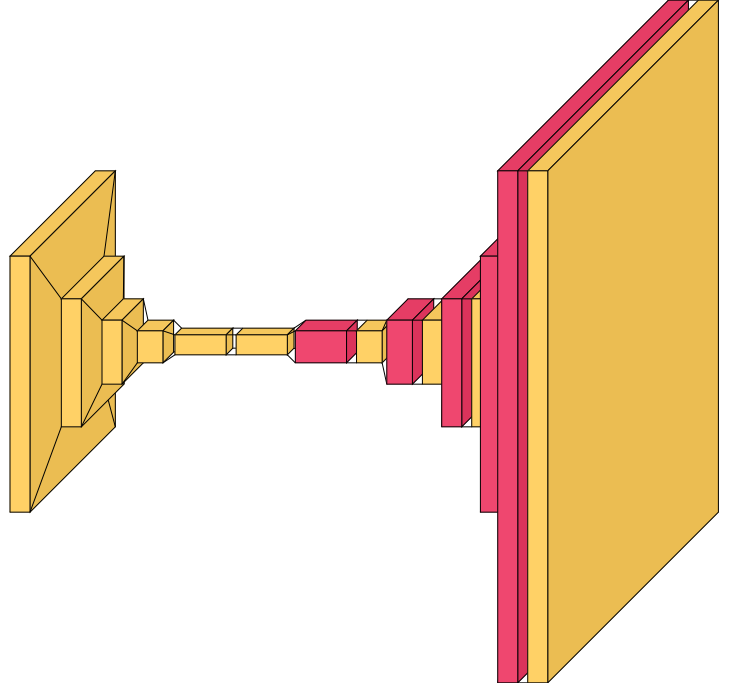

In [53]:
model.compile(optimizer="adam", loss='mse', metrics=['accuracy'])
model.summary()
visualkeras.layered_view(model)

### Training for model selection

Performing `model selection` I train with a reduce number of training examples and validation examples. In fact, in order to speed up the selection step I tested only a (discrete) subset of the entire dataset. In this phase I don't want to precisely tune my model but instead search for the right architecture that will be refined by the next `hyper-parameter tuning` step.

In [ ]:
training_size = 800
valid_size = 200

In [ ]:
history = model.fit(
    X_train[:training_size], Y_train[:training_size],
    validation_data=(X_valid[:valid_size], Y_valid[:valid_size]),
    epochs=25, 
    batch_size=16)

In [ ]:
plot_history(history.history,model.name)

valid_loss, valid_acc = model.evaluate(X_valid[:valid_size], Y_valid[:valid_size], batch_size=16, verbose=0)

print(f"[Model selection] Validation loss: {valid_loss} accuracy: {valid_acc}")

json.dump(history.history, open(history_path+model.name+"-ms.json", 'w'))
model.save(models_path+model.name+"-ms")

### Overall comparison for model selection

In [ ]:
plot_history_comparison(True,(8,5))

---

## Hyper-parameter tuning

```
Neurons:
    - L: 64-32-16-32-64
    - M: 128-64-32-64-128
    - H: 256-128-64-128-256
    
Filters:    
    - L: 16-32-64-64-32-16
    - H: 32-64-128-128-64-32
    
Strides : Y/N

Batch Norm: Y/N

Epochs: 25-50
```

```javascript
[Hyper-parameters tuning] Validation loss: 0.013062547892332077 accuracy: 0.6814773082733154 (v1)
[Hyper-parameters tuning] Validation loss: 0.013182152062654495 accuracy: 0.6792629957199097 (v2)
[Hyper-parameters tuning] Validation loss: 0.012751569971442223 accuracy: 0.6851961016654968 (v3)
[Hyper-parameters tuning] Validation loss: 0.013202700763940811 accuracy: 0.6727843880653381 (v4)
[Hyper-parameters tuning] Validation loss: 0.014923742972314358 accuracy: 0.6527038216590881 (v5)

Test loss: 0.012100797146558762 accuracy: 0.6845739483833313
```

In [40]:
model = Sequential(name=("Polychromify_v3"))
# Encoder
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

# Decoder
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))

# Output layer
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))

In [41]:
model.compile(optimizer="adam", loss='mse', metrics=['accuracy'])
model.summary()

Model: "Polychromify_v3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_95 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
dense_15 (Dense)             (None, 128, 128, 256)     33024     
_________________________________________________________________
dense_16 (Dense)             (None, 128, 128, 128)     32896     
_________________________________________________________________
dense_17 (Dense)             (None, 128, 128, 64)      8256      
_________________________________________________________________
dense_18 (Dense)             (None, 128, 128, 128) 

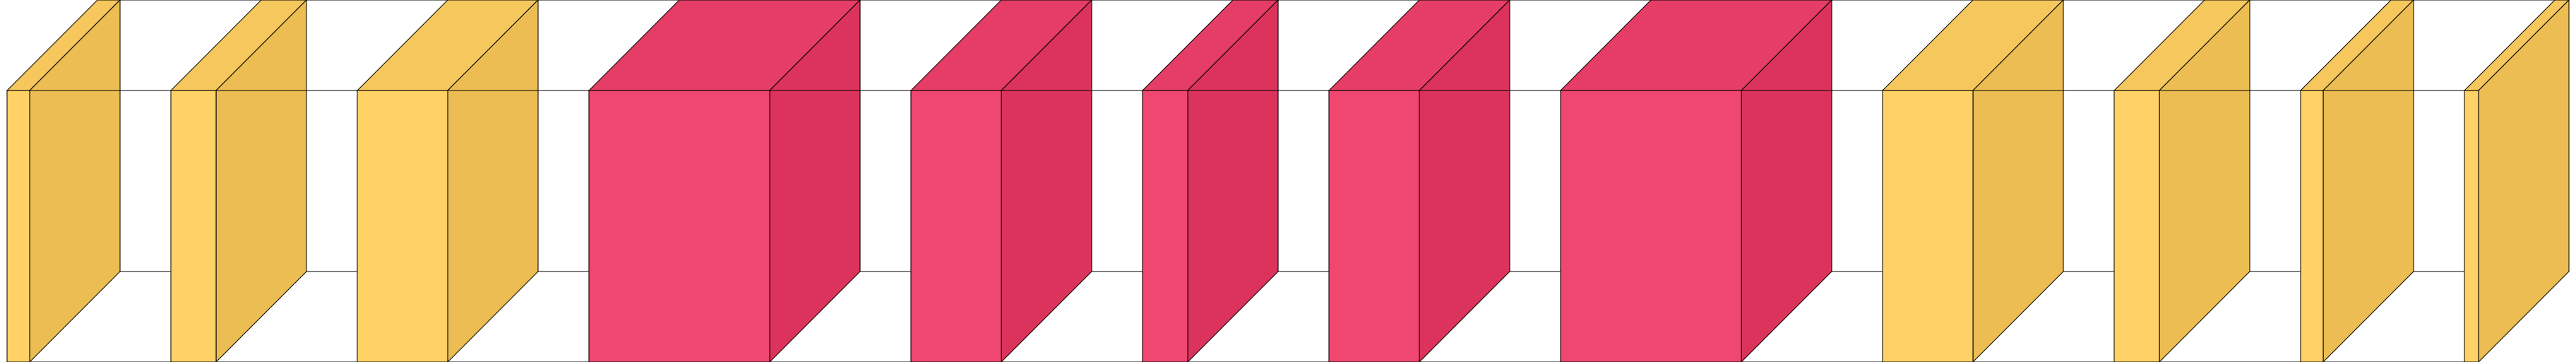

In [46]:
visualkeras.layered_view(model,spacing=200, scale_xy=3, scale_z=1, max_z=1000)

In [ ]:
history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=25, batch_size=32)

In [ ]:
plot_history(history.history,model.name)

valid_loss, valid_acc = model.evaluate(X_valid, Y_valid, batch_size=32, verbose=0)

print(f"[Hyper-parameters tuning] Validation loss: {valid_loss} accuracy: {valid_acc}")

In [ ]:
# saving model & history to disk
json.dump(history.history, open(history_path+model.name+".json", 'w'))
model.save(models_path+model.name)

### Overall comparison

In [ ]:
plot_history_comparison(False,(9,6))

---

### Load model+history from disk

Model: "Polychromify_v3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_491 (Conv2D)          (None, 128, 128, 16)      160       
_________________________________________________________________
conv2d_492 (Conv2D)          (None, 128, 128, 32)      4640      
_________________________________________________________________
conv2d_493 (Conv2D)          (None, 128, 128, 64)      18496     
_________________________________________________________________
dense_125 (Dense)            (None, 128, 128, 256)     16640     
_________________________________________________________________
dense_126 (Dense)            (None, 128, 128, 128)     32896     
_________________________________________________________________
dense_127 (Dense)            (None, 128, 128, 64)      8256      
_________________________________________________________________
dense_128 (Dense)            (None, 128, 128, 128) 

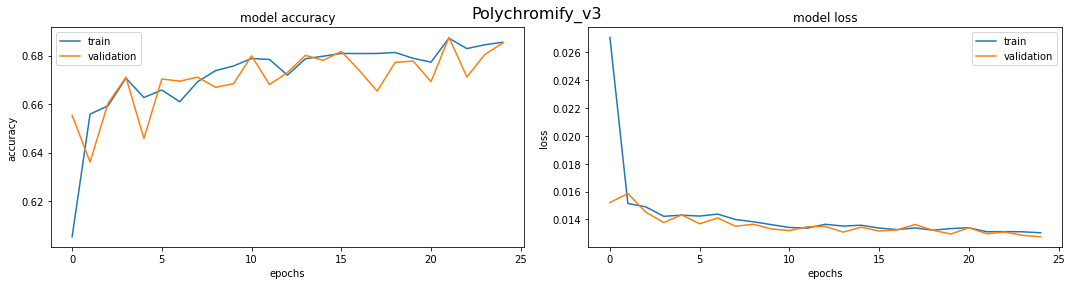

In [63]:
model_name = "Polychromify_v3"

model = tf.keras.models.load_model(
    models_path+model_name,
    custom_objects=None,
    compile=True)

model.summary()

history_loaded = json.load(open(history_path+model_name+".json", 'r'))   
plot_history(history_loaded,model_name)

## Testing

Final model testing.

> I do **not** validate on this set, the following metrics are just meant to be _reported_ and not used as indicators.

In [ ]:
test_loss, test_acc = model.evaluate(X_test, Y_test, batch_size=32, verbose=1)

print(f"Test loss: {test_loss} accuracy: {test_acc}")

## Visualization

### Visualization from test set

In [ ]:
for i, x in enumerate(X_test[:-10]):     
    
    img_color = []
    img_color.append(x)
    img_color = np.array(img_color, dtype=float)

    output = model.predict(img_color)
    output = output*128
    
    result = np.zeros((SIZE, SIZE, 3))
    result[:,:,0] = img_color[0][:,:,0]
    result[:,:,1:] = output[0]

    recolored = lab2rgb(result)
    
    original = np.zeros((SIZE, SIZE, 3))
    original[:,:,0] = x[:,:,0]
    original[:,:,1:] = Y_test[i]*128
    
    original = lab2rgb(original)
    
    plot_comparison(original, recolored)

### Visualization with raw images

Lossy conversion from float32 to uint8. Range [0.013464312069118023, 249.9630889892578]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


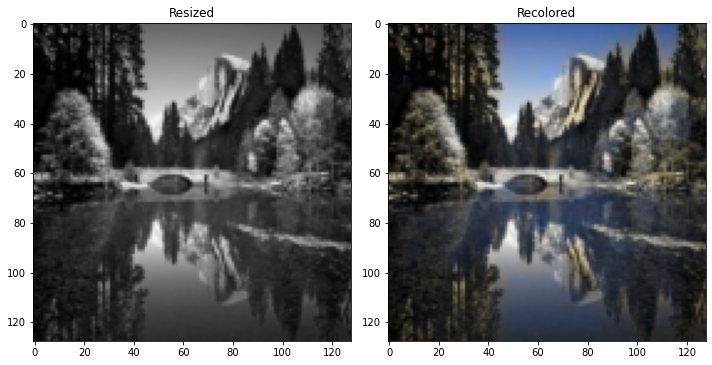

Lossy conversion from float32 to uint8. Range [0.00504363514482975, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


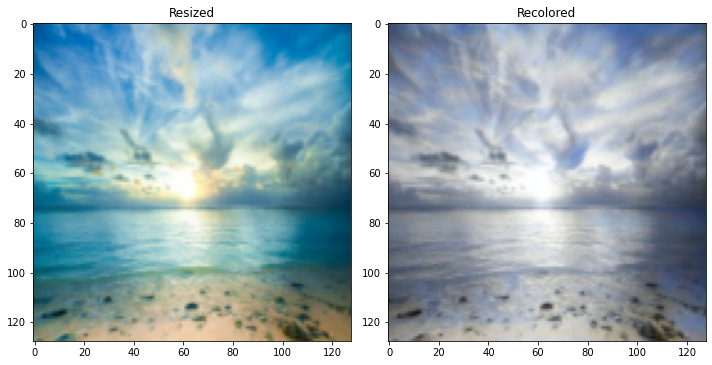

Lossy conversion from float32 to uint8. Range [0.37153851985931396, 254.99501037597656]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


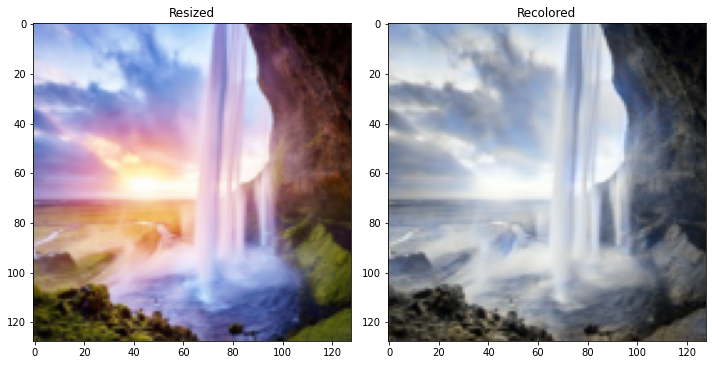

Lossy conversion from float32 to uint8. Range [0.053938113152980804, 251.92059326171875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


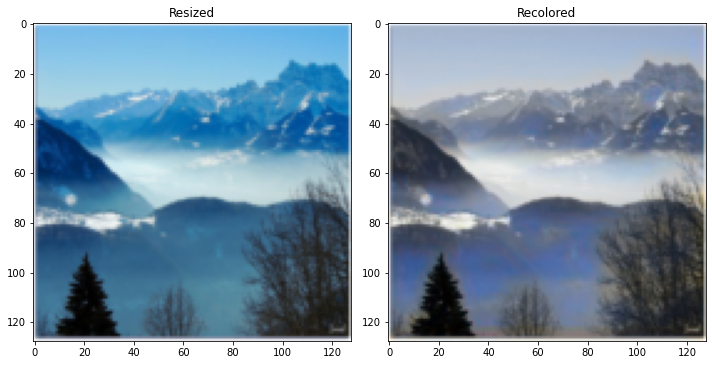

Lossy conversion from float32 to uint8. Range [14.510860443115234, 254.9970245361328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


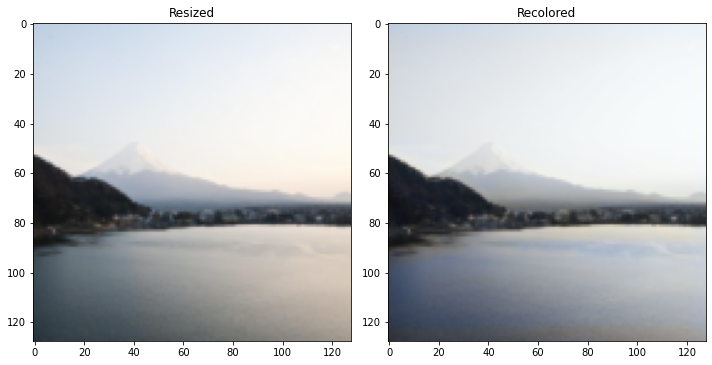

In [74]:
test_path = "../test/" # modify here to load images from a different folder

for i, img_path in enumerate(os.listdir(test_path)):    
    
    img_color = []
    img = img_to_array(load_img(test_path+img_path))
    original_shape = img.shape
    
    img = resize(img, (SIZE,SIZE))
    
    img_color.append(img)
    
    img_color = np.array(img_color, dtype=float)
    img_color = rgb2lab(1.0/255*img_color)[:,:,:,0]
    img_color = img_color.reshape(img_color.shape+(1,))

    output = model.predict(img_color)
    output = output*128
    
    result = np.zeros((SIZE, SIZE, 3))
    result[:,:,0] = img_color[0][:,:,0]
    result[:,:,1:] = output[0]

    recolored = lab2rgb(result)
    # to resize back to original shape
    # recolored = resize(recolored, (original_shape[0],original_shape[1]))
    imsave("../results/"+str(i)+".png", img)
    imsave("../results/"+str(i)+"-polychromify.png", recolored)
    
    plot_comparison(img, recolored,cast=True)

### Results comparison between different methods

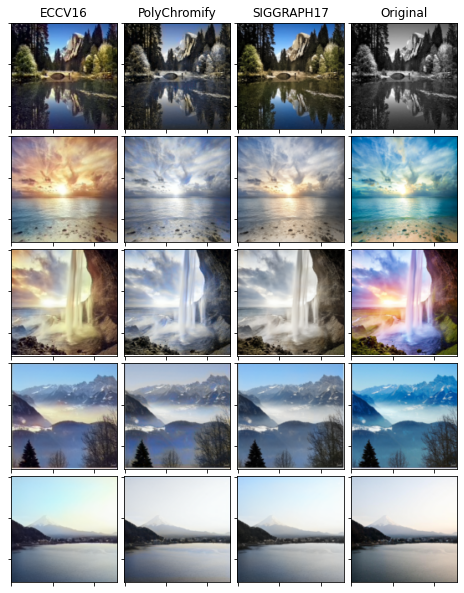

In [90]:
images = []
results_path = "../results/"


for img_path in os.listdir(results_path):
    
    img_color = []
    img = img_to_array(load_img(results_path+img_path))
    
    img = resize(img, (SIZE,SIZE))
    images.append(img)
    
fig = plt.figure(figsize=(8., 16.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(5, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, (i,im) in zip(grid, enumerate(images)):
    # Iterating over the grid returns the Axes.
    ax.imshow(im.astype('uint8'))
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    if i == 0:
        ax.set_title("ECCV16")
    elif i == 1:
        ax.set_title("PolyChromify")
    elif i == 2:
        ax.set_title("SIGGRAPH17")
    elif i == 3:
        ax.set_title("Original")

plt.show()